In [150]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device:  mps


# Load PCA model

In [151]:
import pickle
from sklearn.kernel_ridge import KernelRidge
from morphogenesis.decomposition.decomposition_model import SVDPipeline

with open('MutantSqhSVD.pkl', 'rb') as f:
    sqh_model = pickle.load(f)

with open('MutantVelSVD.pkl', 'rb') as f:
    vel_model = pickle.load(f)

with open('MutantKernelRidge.pkl', 'rb') as f:
    skmodel = pickle.load(f)

keep = np.ones(sqh_model.n_components, dtype=bool)
keep[skmodel.n_features_in_:] = False

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    features = sqh_model.transform(y)[:, keep]
    features = skmodel.predict(features)
    return vel_model.inverse_transform(features, keep)


# Load eCadherin profile

In [152]:
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    s0 = data['fields/c'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

# Fly closed loop

100%|██████████| 6/6 [00:00<00:00, 50.47it/s]


(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
(5, 236, 200)
Using custom RHS
Using covariant gradient
Initializing
Using scipy solve_ivp


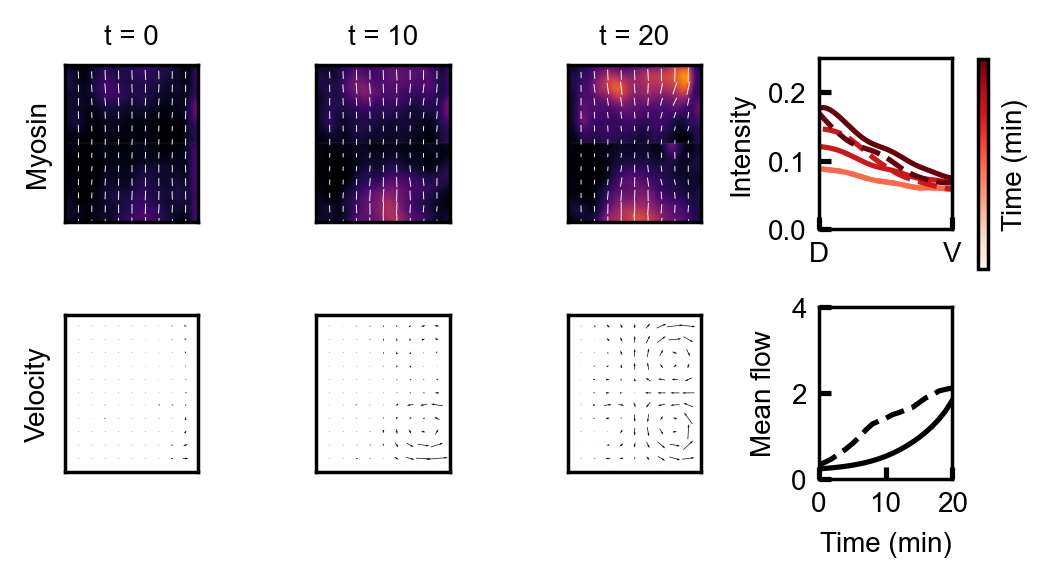

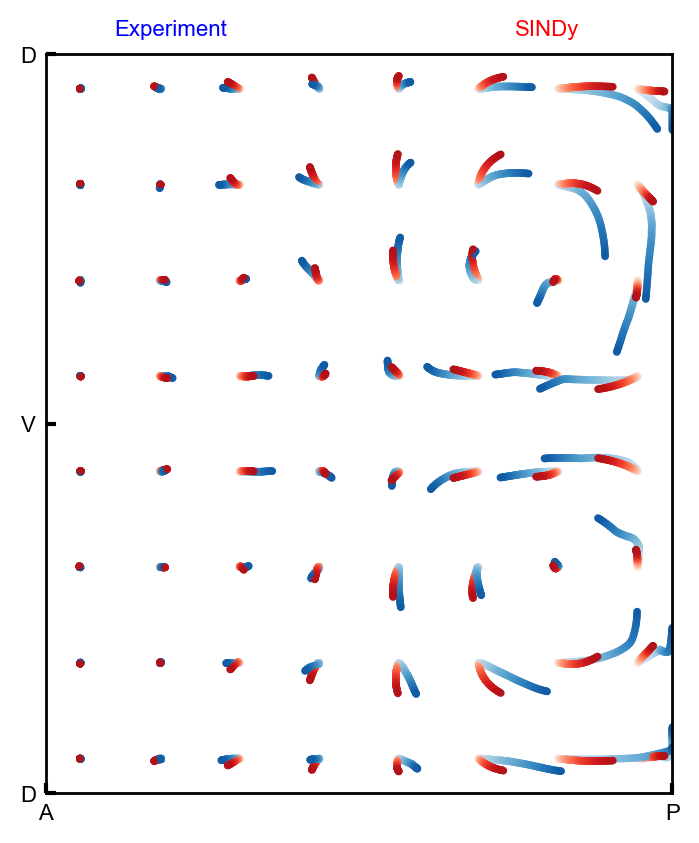

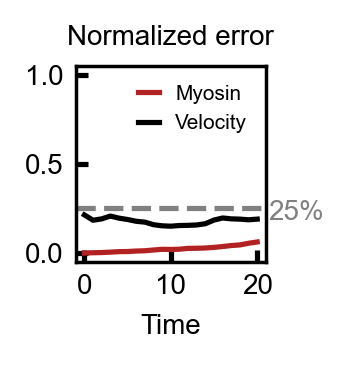

In [153]:
from mutant_datasets import TwistDataset
dataset = TwistDataset(tmin=0, tmax=20)
m0, v0, t0 = dataset.get_trajectory(202007171400)

print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *m0.shape[-2:]])
])
print(y0.shape)


def rhs_eCad(self, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
    '''
    trm = self.einsum_('kkyx->yx', m)
    trE = self.einsum_('kkyx->yx', E)

    rhs  = -(0.110 - 0.095 * s) * m #Detachment
    rhs +=	(0.802 - 0.611 * s) * trm * m #Tension recruitment
    rhs +=	(0.708 + 0.133 * s) * m * trE #Strain recruitment
    rhs +=	(0.064 - 0.044 * s) * trm * self.gamma_dv_ #Hoop stress recruitment

    return rhs

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad)
model.fit(y0[None])

m, s, v = model.integrate(y0, t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0, mmin=0.05, mmax=0.30)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)

100%|██████████| 3/3 [00:00<00:00, 559.91it/s]


(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
(5, 236, 200)
Using custom RHS
Using covariant gradient
Initializing
Using scipy solve_ivp


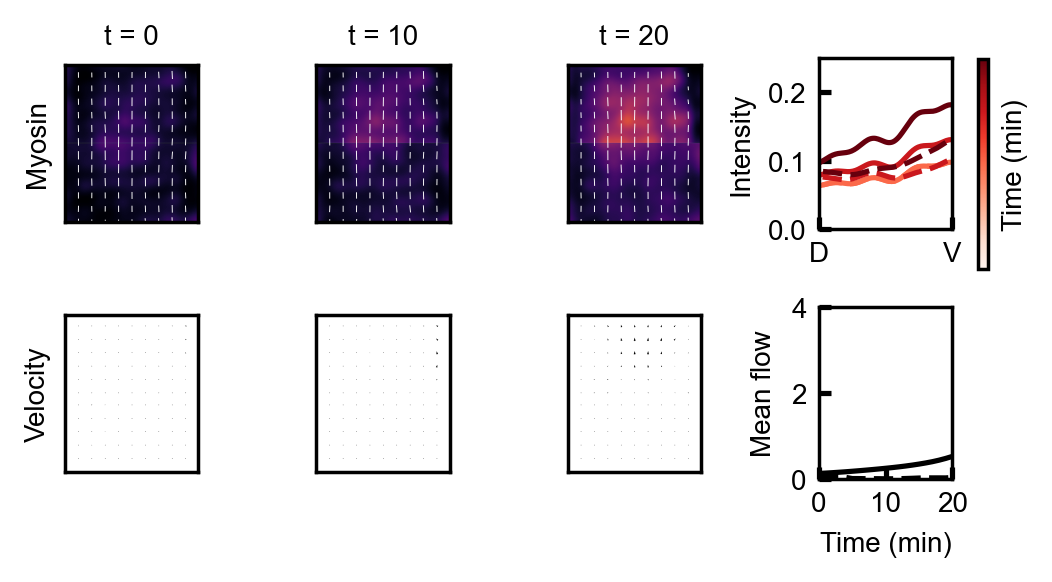

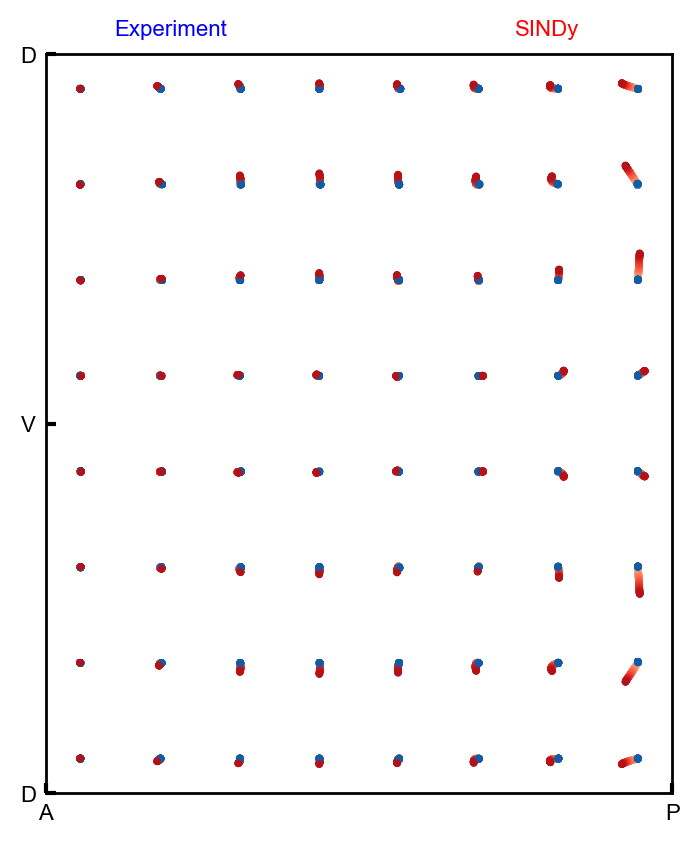

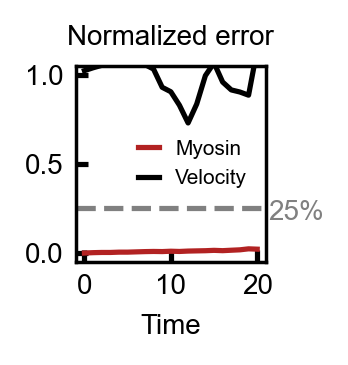

In [154]:
from mutant_datasets import TollDataset
dataset = TollDataset(tmin=0, tmax=20)
m0, v0, t0 = dataset.get_trajectory(202101191940)
print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    0.1 * (s0[0].reshape([1, 236, 200]) - np.mean(s0[0])) + np.mean(s0[0]),
])
print(y0.shape)

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad)
model.fit(y0[None])

m, s, v = model.integrate(y0, t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0, mmin=0.05, mmax=0.30)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)

100%|██████████| 4/4 [00:00<00:00, 715.69it/s]


(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
(5, 236, 200)
Using custom RHS
Using covariant gradient
Initializing
Using scipy solve_ivp
0.009185394295916385 0.07327801523831295


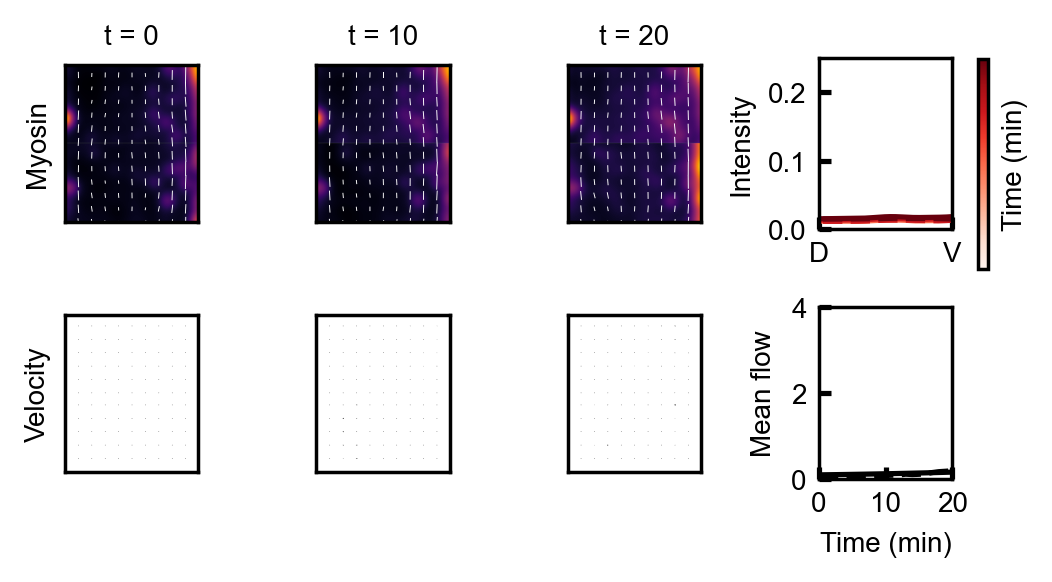

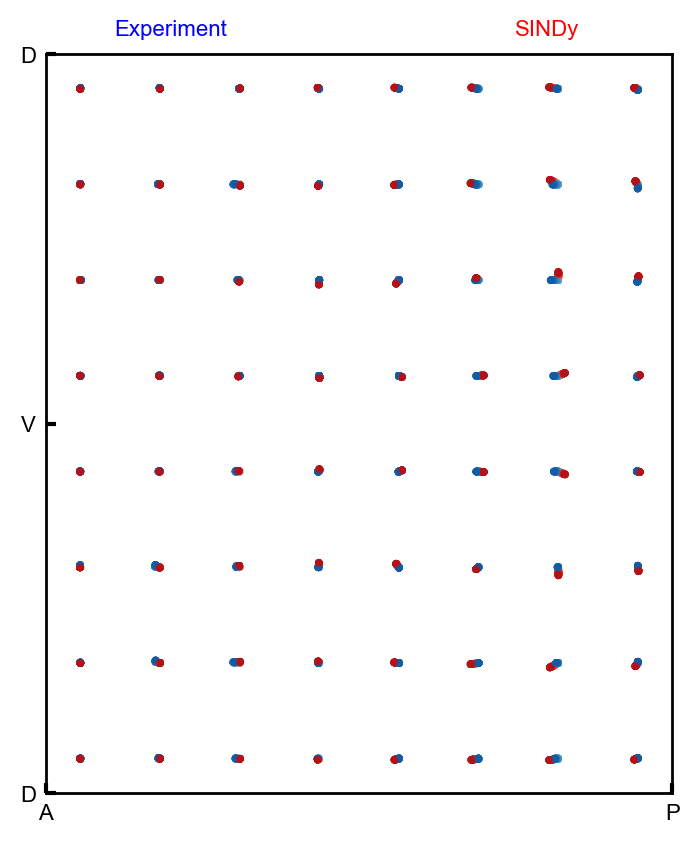

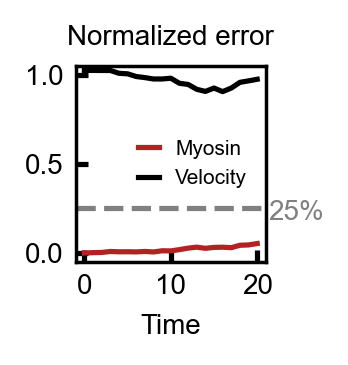

In [159]:
from mutant_datasets import SpaetzleDataset
dataset = SpaetzleDataset(tmin=0, tmax=20)
m0, v0, t0 = dataset.get_trajectory(201712201630)
print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    0.1 * (s0[0].reshape([1, 236, 200]) - np.mean(s0[0])) + np.mean(s0[0]),
])
print(y0.shape)

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad)
model.fit(y0[None])

m, s, v = model.integrate(y0, t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)

# Point of comparison: WT models

In [142]:
import pickle
from sklearn.kernel_ridge import KernelRidge
from morphogenesis.dataset import AtlasDataset
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model

# Collect model
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D')
sqh_model = get_decomposition_model(sqh_dataset, model_name='SVDPipeline_PMGCrop')

vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D')
vel_model = get_decomposition_model(vel_dataset, model_name='SVDPipeline_NoCrop')

with open('../04.TranslationNetworks/FlowKernelRidge.pkl', 'rb') as f:
    skmodel = pickle.load(f)

keep = np.ones(sqh_model.n_components, dtype=bool)
keep[skmodel.n_features_in_:] = False

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    features = sqh_model.transform(y)[:, keep]
    features = skmodel.predict(features)
    return vel_model.inverse_transform(features, keep)

100%|██████████| 1/1 [00:00<00:00, 177.90it/s]


(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
Using custom RHS
Using covariant gradient
Initializing
Using scipy solve_ivp


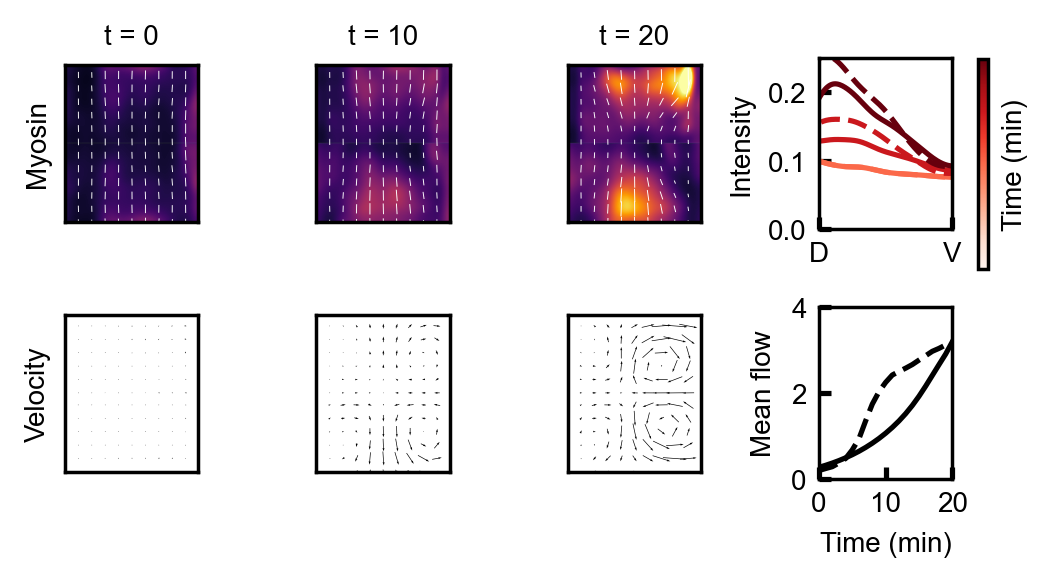

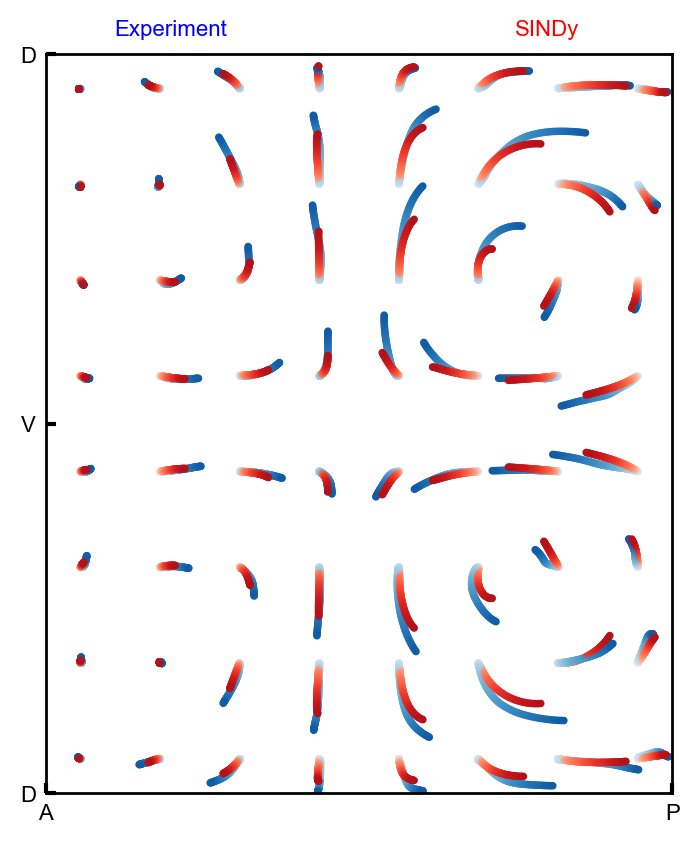

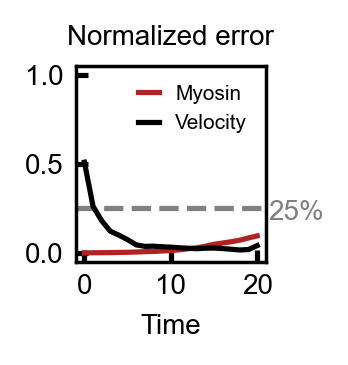

In [145]:
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.flow_networks.translation_models import VAE, MaskedVAE
from morphogenesis.flow_networks.forecasting_models import MaskedVAE_Evolver
from morphogenesis.forecasting.plot_utils import *
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from pprint import pprint
#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *m0.shape[-2:]])
])

def rhs_eCad(self, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
    '''
    trm = self.einsum_('kkyx->yx', m)
    trE = self.einsum_('kkyx->yx', E)

    rhs  = -(0.110 - 0.095 * s) * m #Detachment
    rhs +=	(0.802 - 0.611 * s) * trm * m #Tension recruitment
    rhs +=	(0.708 + 0.133 * s) * m * trE #Strain recruitment
    rhs +=	(0.064 - 0.044 * s) * trm * self.gamma_dv_ #Hoop stress recruitment

    return rhs


model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad)
model.fit(y0[None])

m, s, v = model.integrate(y0, t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0, mmin=0.05, mmax=0.30)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)